# Basic Network

This network achieves a final testing accuracy of 97.5%

This notebook a very close re-implementation of the work done here: https://towardsdatascience.com/handwritten-digit-mnist-pytorch-977b5338e627  
It also includes some of my personal notes and intepretations of the process of using Pytorch as well as some parameter adjustments.

In [1]:
import torch
import torchvision
import matplotlib.pyplot as plt
from torch import nn, optim
from time import time

First, load in the data that we have already saved in ./data/MNIST/processed.   

We choose a to use a batchsize of 64 and can shuffle the data in this step.  

Luckily, we know a bit about what to expect from MNIST data. We know that each image will be of a handwritten digit, between 0 and 9. We also know that they will be grayscale already.  

In this case, we only need to preform a simple normalization to get the 0-255 values to be between -1 and 1 (this improves NN preformance). 

In [2]:
# Create a Transform which can be applied in the loading step
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(), 
                                            torchvision.transforms.Normalize((0.5,), (0.5,)),])

# Creates (downloading if needed) a training a test set from the MNIST dataset and applies the transformations to it
trainset = torchvision.datasets.MNIST('../data', download=True, train=True, transform=transform)
valset = torchvision.datasets.MNIST('../data', download=True, train=False, transform=transform)

# Creates a dataloader based off of the training and test sets. I choose a batch size of 60 since the original MNIST dataset has 6000 images in the training set and 1000 images in the validation set.
# This gives us 120 and 20 batches respectively. 
trainloader = torch.utils.data.DataLoader(trainset, batch_size=50, shuffle=True)
testloader = torch.utils.data.DataLoader(valset, batch_size=50, shuffle=True)

In [3]:
dataiter = iter(trainloader)    #convert the loader object to an iterable so that we can easily visualize some images
images, labels = dataiter.next()   

print(images.shape)     #prints the shape of the tensor representing a single batch of our data
print(labels.shape)     #prints the shape of the correpsonding labels

torch.Size([50, 1, 28, 28])
torch.Size([50])


We see two lines:  
The first line shows our training set has 50 images, each image is a single channel(grayscale), and each of those has a shape of 28x28.  
The second line shows we also have he 50 corresponding labels.  

Below we see what makes up a specific image:

In [4]:
images[0]

tensor([[[-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1

In [5]:
print(f'Shape: {images[0].shape}\nmin_val: {images[0].min()}\nmax_val: {images[0].max()}\nmean: {images[0].mean()}\nmedian: {images[0].median()}\nreal_label: {labels[0]}')

Shape: torch.Size([1, 28, 28])
min_val: -1.0
max_val: 1.0
mean: -0.6738895773887634
median: -1.0
real_label: 9


For this particular image, the real value is 5. There are values in the images that range from -1 to 1 with an average of ~-0.75 but a median value of -1. This means more than half of the pixels have a value of -1. 

Lets now display the image:

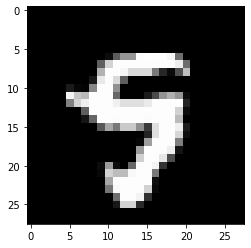

In [6]:
# Pytorch allows you to easily swap between tensors and numpy arrays. 
# Here we use numpy.squeeze to remove the unused color channels and use matplotlib.imshow with a colormap that corresponds to the actual colors (-1 -> black, 1->white)

plt.imshow(images[0].numpy().squeeze(), cmap='gray')

## Creating a model

Here we will define the actual network:  
This will use three linear layers. The first two hidden layers will used a ReLU activation function. The final Layer will use LogSoftmax to determine which catagory a given image fits in (0-9). 

In [7]:
# Variables to easily adjust the shape/size of the network
input_size = 784            #this is the number of pixels in the image (28x28)
hidden_sizes = [128, 64]    #this is the number of nodes in the hidden layers
output_size = 10            #this is the number of labels we need

model = nn.Sequential(nn.Linear(input_size, hidden_sizes[0]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[0], hidden_sizes[1]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[1], output_size),
                      nn.LogSoftmax(dim=1))
print(model)

Sequential(
  (0): Linear(in_features=784, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=64, bias=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=10, bias=True)
  (5): LogSoftmax()
)


## Model Training!

Here we train the model: 

In [8]:
criterion = nn.NLLLoss()

optimizer = optim.SGD(model.parameters(), lr=0.003, momentum=0.9)
time0 = time()
epochs = 15
for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        # Flatten MNIST images into a 784 long vector
        images = images.view(images.shape[0], -1)
    
        # Training pass
        optimizer.zero_grad()
        
        output = model(images)
        loss = criterion(output, labels)
        
        #This is where the model learns by backpropagating
        loss.backward()
        
        #And optimizes its weights here
        optimizer.step()
        
        running_loss += loss.item()
    else:
        print("Epoch {} - Training loss: {}".format(e, running_loss/len(trainloader)))
print("\nTraining Time (in minutes) =",(time()-time0)/60)

Epoch 0 - Training loss: 0.5715019228309393
Epoch 1 - Training loss: 0.25769345826779805
Epoch 2 - Training loss: 0.19212223297140252
Epoch 3 - Training loss: 0.15461503795192888
Epoch 4 - Training loss: 0.12776106013994043
Epoch 5 - Training loss: 0.11034000055243572
Epoch 6 - Training loss: 0.09724492337399472
Epoch 7 - Training loss: 0.08701341342724239
Epoch 8 - Training loss: 0.07780841870699078
Epoch 9 - Training loss: 0.06956941463732316
Epoch 10 - Training loss: 0.06327288172673434
Epoch 11 - Training loss: 0.057840389339253305
Epoch 12 - Training loss: 0.05256749699765351
Epoch 13 - Training loss: 0.048819535074386904
Epoch 14 - Training loss: 0.04435507242470824

Training Time (in minutes) = 2.3195499579111734


In [11]:
correct_count, all_count = 0, 0
for images,labels in testloader:
  for i in range(len(labels)):
    img = images[i].view(1, 784)
    with torch.no_grad():
        logps = model(img)

    
    ps = torch.exp(logps)
    probab = list(ps.numpy()[0])
    pred_label = probab.index(max(probab))
    true_label = labels.numpy()[i]
    if(true_label == pred_label):
      correct_count += 1
    all_count += 1

print("Number Of Images Tested =", all_count)
print("\nModel Accuracy =", (correct_count/all_count))

Number Of Images Tested = 10000

Model Accuracy = 0.9753
